In [1]:
### Imports

In [1]:
import ast
import datetime
import dateutil.parser
import distutils.dir_util
import glob
import IPython.display
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import pickle
import pyautogui
import pytz
import re
import requests
import selenium
import shutil
import statsapi
import statsmodels.formula.api as smf
import time
import unidecode
import warnings
import webbrowser
import xlrd
import random
import urllib
from urllib.request import urlopen, Request
import zipfile

from bs4 import BeautifulSoup
from datetime import date
from IPython.display import display, Javascript
from joblib import Parallel, delayed
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium import webdriver
from openpyxl import load_workbook
from functools import partial

from statsapi import get
from pydfs_lineup_optimizer import get_optimizer, Site, Sport, Player, TeamStack, PlayerFilter, RandomFantasyPointsStrategy

os.chdir(r"C:\Users\james\Documents\MLB\Code")

# from Utilities import *
# from Classes import *
# from simulation_functions_three import *

import smtplib
import ssl
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders

# Ensure the warning is ignored only once
warnings.simplefilter(action="ignore")

# Display the DataFrame
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# Set paths
model_path = r"C:\Users\james\Documents\MLB\Code\Models"
baseball_path = r"C:\Users\james\Documents\MLB\Data2"
download_path = r"C:\Users\james\Downloads"

In [2]:
# Today's Date
# YYYY-MM-DD (datetime)
todaysdate_dt = datetime.date.today()

# YYYY-MM-DD (string)
todaysdate_dash = str(todaysdate_dt)

# MM/DD/YYYY
todaysdate_slash = todaysdate_dash.split("-")
todaysdate_slash = todaysdate_slash[1] + "/" + todaysdate_slash[2] + "/" + todaysdate_slash[0]

# YYYYMMDD
todaysdate = todaysdate_dash.replace("-", "")

## MM-DD-YYYY
todaysdate_dash = todaysdate[:4] + "-" + todaysdate[4:6] + "-" + todaysdate[6:]

In [3]:
# This reads in a map of team name, codes, and the shorthand MLB uses in their URLs
team_map = pd.read_csv(os.path.join(baseball_path, "Utilities", "Team Map.csv"))

# We just need teams right now
team_map = team_map[['FULLNAME', 'BBREFTEAM', 'MLBURL', 'FANGRAPHSTEAM', 'VENUE_ID', 'SFBBTEAM', 'DKTEAM', 'ROTOWIRETEAM', 'FANPROSTEAM']]

In [4]:
# Read in history file        
history = pd.read_csv(os.path.join(baseball_path, "Utilities", "Contests.csv"))

# Sort by date, then draft group, then fee
history.sort_values(['date', 'draftGroupId', 'entryFee'], ascending=False)
# Keep only one observation per draft group 
history.drop_duplicates('draftGroupId', keep='first', inplace=True)

history_full = history.copy()
history = history.query('result == 1').query('payout == 1').query('salary == 1')


history = history.reset_index(drop=True)
history['date'] = history['date'].astype('int').astype('str')

In [5]:
%run "11. Projections.ipynb"
%run "Utilities.ipynb"

In [18]:
%run "B1. Evaluate Scores.ipynb"

In [19]:
merged_df = gambling_dashboard(team_map, "20220401", "20230816")

merged_df['BetWin$Exp'] = np.where(merged_df['AwayWin$Exp'] > merged_df['HomeWin$Exp'], merged_df['AwayWin$Exp'], merged_df['HomeWin$Exp'])
merged_df['BetWin$Act'] = np.where(merged_df['AwayWin$Exp'] > merged_df['HomeWin$Exp'], merged_df['AwayWin$Act'], merged_df['HomeWin$Act'])

In [20]:
bet_df = merged_df[merged_df['BetWin$Exp'] > 100]
bet_df.describe()

,Away,Home,AwayWin%,HomeWin%,AwayWin$Exp,HomeWin$Exp,AwayWin$Act,HomeWin$Act,BetWin$Exp,BetWin$Act
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,4.137984,4.290790,0.461240,0.538760,100.286205,101.642192,97.448430,92.683648,123.397204,92.213255
std,0.552032,0.558823,0.053778,0.053778,28.698811,26.049435,107.352078,93.550911,20.315560,116.068841
min,2.607000,2.691000,0.300000,0.361000,43.793878,51.538776,0.000000,0.000000,100.025806,0.000000
25%,3.758000,3.917250,0.426000,0.503000,77.471703,81.383349,0.000000,0.000000,107.520000,0.000000
50%,4.115000,4.235000,0.461000,0.539000,91.880000,100.138462,0.000000,133.615819,118.232206,0.000000
75%,4.467000,4.595750,0.497000,0.574000,118.295750,118.101326,190.909091,171.428571,132.801000,214.000000
max,6.353000,6.925000,0.639000,0.700000,214.000000,221.835000,440.000000,370.000000,221.835000,440.000000


# Previous
92.422666


In [21]:
# This doesn't quite work
# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(bet_df['BetWin$Act'], 100)

print(p_value)

# Set the significance level (alpha)
alpha = 0.05


# Check if the p-value is less than alpha
if (p_value < alpha) and np.mean(bet_df['BetWin$Act']) > 100:
    print("The average value is statistically greater than 100.")
else:
    print("The average value is not statistically greater than 100.")

0.0039139087309048425
The average value is not statistically greater than 100.


In [22]:
%run "B2. Evaluate Projections.ipynb"

In [23]:
# Run all
history.reset_index(drop=True, inplace=True)
daily_comparable_dfs = []
daily_complete_dfs = []
for i in range(len(history)): 
    # Extract date and contestKey
    date = str(history['date'][i])
    date = date.replace(".0", "")
    contestKey = history['contestKey'][i]
    print(date, contestKey)
    if date <= "20230816":
        try:
            # Read in projection evaluations
            complete_df = evaluate_projections_post(contestKey)
            daily_complete_dfs.append(complete_df)
            # Make comparable
            comparable_df = compare_projections(complete_df)
            if len(comparable_df) > 30:
                daily_comparable_dfs.append(comparable_df)
        except:
            pass

print("Complete")
all_df = pd.concat(daily_comparable_dfs, axis=0)
all_df = compare_projections(all_df)


all_df_complete = pd.concat(daily_complete_dfs, axis=0)

20230823 148743384
20230823 148743353
20230823 148743286
20230822 148676277
20230822 148676216
20230821 148600591
20230821 148600505
20230820 148538281
20230820 148538240
20230819 148478844
20230819 148478807
20230819 148478756
20230818 148428187
20230818 148424739
20230817 148362209
20230817 148362093
20230816 148317086
RotoWire Didn't Merge:
Series([], Name: Name, dtype: object)
DFF Didn't Merge:
26    Cedric Mullins
Name: Name, dtype: object
Rankings:
1. MSE_DFF: 37.871978846153844
2. MSE_Roto: 40.162558974358966
3. MSE_Me: 42.95659001019229
There were 39 players we all projected.
I beat DFF on 35.9% of players (Batters: 37.1%, Pitchers: 25.0%).
I beat RotoWire on 46.2% of players (Batters: 45.7%, Pitchers: 50.0%).


20230816 148317020
RotoWire Didn't Merge:
Series([], Name: Name, dtype: object)
DFF Didn't Merge:
Series([], Name: Name, dtype: object)
Rankings:
1. MSE_Roto: 51.80986750000002
2. MSE_DFF: 58.120391774999995
3. MSE_Me: 67.63909935543751
There were 40 players we all proj

Complete
Rankings:
1. MSE_DFF: 57.731674609142075
2. MSE_Roto: 58.16856317753808
3. MSE_Me: 58.56483704015189
There were 29205 players we all projected.
I beat DFF on 51.4% of players (Batters: 52.0%, Pitchers: 45.8%).
I beat RotoWire on 53.4% of players (Batters: 54.2%, Pitchers: 46.8%).

In [13]:
%run "B3. Evaluate Payouts.ipynb"

In [14]:
history = history[history['entryFee'] == 4]
history = history[history['date'] <= "20230816"]

In [15]:
# Create list of contests
contestKeys = list(history['contestKey']) 
print(len(contestKeys))

# Run all in parallel
all_sims = Parallel(n_jobs=-2, verbose=5)(delayed(read_sims2)(contestKey) for contestKey in contestKeys)

# Create dataframe with every payout for each lineup
payout_df = pd.concat(all_sims, axis=0)

# Print average payout across every possible lineup
payout_df['Payout'].mean()

267


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-2)]: Done 132 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-2)]: Done 267 out of 267 | elapsed:  1.1min finished


4.055076983044241

In [16]:
# 4.055076983044241


In [17]:
metrics = ['AvgPointsPerGame', 'Sim STD', 'Plus1', 'Plus2', 'Plus3', 'Plus4', 'Plus5', 'Tail', 'Rarity', 'Batter', 'Pitcher', 'Choose', 'Choose2']

In [18]:
%%time
payout_df = add_metrics(payout_df)

AvgPointsPerGame
Sim STD
Plus1
Plus2
Plus3
Plus4
Plus5
Tail
Rarity
Batter
Pitcher
Choose
Choose2
CPU times: total: 7.09 s
Wall time: 7.5 s


In [19]:
lineups = 10
for metric in metrics:
    profit = evaluate_metric(f'{metric} Rank', lineups)
    print("With the {} metric, the top {} lineups would average a profit of ${:.2f}.".format(metric, lineups, profit))

With the AvgPointsPerGame metric, the top 10 lineups would average a profit of $0.79.
With the Sim STD metric, the top 10 lineups would average a profit of $-0.08.
With the Plus1 metric, the top 10 lineups would average a profit of $0.60.
With the Plus2 metric, the top 10 lineups would average a profit of $0.57.
With the Plus3 metric, the top 10 lineups would average a profit of $0.34.
With the Plus4 metric, the top 10 lineups would average a profit of $0.30.
With the Plus5 metric, the top 10 lineups would average a profit of $0.29.
With the Tail metric, the top 10 lineups would average a profit of $-0.28.
With the Rarity metric, the top 10 lineups would average a profit of $-1.20.
With the Batter metric, the top 10 lineups would average a profit of $-0.48.
With the Pitcher metric, the top 10 lineups would average a profit of $-1.40.
With the Choose metric, the top 10 lineups would average a profit of $-0.52.
With the Choose2 metric, the top 10 lineups would average a profit of $-0.77.

With the AvgPointsPerGame metric, the top 10 lineups would average a profit of $0.79.
With the Sim STD metric, the top 10 lineups would average a profit of $-0.08.
With the Plus1 metric, the top 10 lineups would average a profit of $0.60.
With the Plus2 metric, the top 10 lineups would average a profit of $0.57.
With the Plus3 metric, the top 10 lineups would average a profit of $0.34.
With the Plus4 metric, the top 10 lineups would average a profit of $0.30.
With the Plus5 metric, the top 10 lineups would average a profit of $0.29.
With the Tail metric, the top 10 lineups would average a profit of $-0.28.
With the Rarity metric, the top 10 lineups would average a profit of $-1.20.
With the Batter metric, the top 10 lineups would average a profit of $-0.48.
With the Pitcher metric, the top 10 lineups would average a profit of $-1.40.
With the Choose metric, the top 10 lineups would average a profit of $-0.52.
With the Choose2 metric, the top 10 lineups would average a profit of $-0.77.

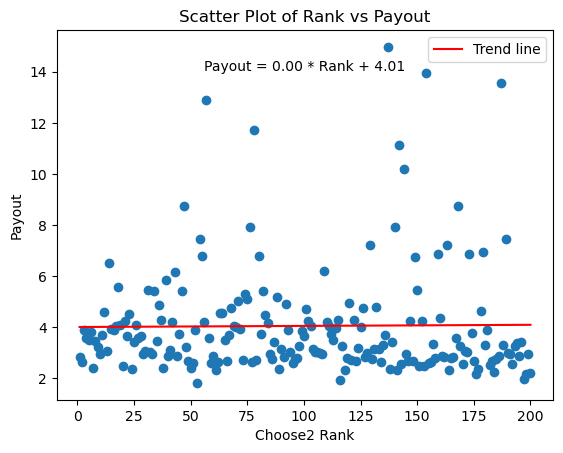

In [20]:
plot_payouts("Choose2")

In [21]:
len(payout_df)

51310